In [1]:
%config Completer.use_jedi = False
%config InlineBackend.figure_format = 'svg'

In [2]:
import restaurants_timeseries.core as core
import restaurants_timeseries.surveyors as surveyors

import GPy
import plotnine as pn
import pandas as pd
import numpy as np
from typing import List
from mizani.formatters import date_format
from fastcore.foundation import patch
import warnings

In [23]:
pn.options.figure_size = figure_size=(15, 4)
RESPONSE = 'visitors'
VAL_DAYS = 45
DAYS_IN_WEEK = 7

def plot_single_timeseries(dat: pd.DataFrame):
    return (
        pn.ggplot(dat, pn.aes('visit_date', 'visitors', color='dataset')) +
        pn.geom_line(pn.aes(group='air_store_id')) +
        pn.scale_x_date(breaks="1 week", labels=date_format("%b %d '%y")) +
        pn.theme_bw() +
        pn.theme(axis_text_x=pn.element_text(angle=90*3, size=9),
                 panel_grid=pn.element_blank(),
                 legend_position="top", legend_title=pn.element_blank()))


def make_predictions_frame(days: List[int], means: List[float], 
                           variances: List[float]) -> pd.DataFrame:
    pred_dat = pd.DataFrame({'day': days, 'mean': means, 'var': variances, 'sd': np.sqrt(variances)})
    pred_dat.loc[:, 'mean'] = np.maximum(0.0, pred_dat['mean'])
    pred_dat.loc[:, 'lower_bound'] = np.maximum(0.0, pred_dat['mean'] - 2 * pred_dat['sd'])
    pred_dat.loc[:, 'upper_bound'] = np.maximum(0.0, pred_dat['mean'] + 2 * pred_dat['sd'])
    return pred_dat


class Set:
    def __init__(self, dat, predictors: List[str], response: str = RESPONSE):
        self.data = dat.copy()
        self.X = dat[predictors].to_numpy()
        self.y = dat[[response]].to_numpy()

@patch
def split_datasets(self: surveyors.VisitsSurveyor, val_days: int, predictors: List[str]):
    """
    Splits self.visits into Training and Validation sets, setting the fields `trn` and `val`.
    Also adds the column `dataset` to self.visits.
    """
    self.predictors = predictors
    if len(self.visits['air_store_id'].unique()) > 1:
        raise ValueError(
            "This class only supports a dataframe of a single 'air_store_id' right now.")
    earliest = surveyors.get_earliest_date(self.visits)
    latest = surveyors.get_latest_date(self.visits)
    self.visits['dataset'] = ['Training' if (latest - visit_date).days >= val_days else 'Validation'
                              for visit_date in self.visits['visit_date']]
    self.visits['group'] = 'group' # for plotnine line connections
    split_counts = dict(self.visits.groupby('dataset').count()['air_store_id'])    
    if split_counts['Validation'] != val_days:
        warnings.warn(f"Expected to find {val_days} days in the validation set, " +
                      f"but found {split_counts['Validation']} instead.")
    if split_counts['Training'] < split_counts['Validation']:
        warnings.warn(f"Less training days than validation days: {split_counts}.")
    assert self.visits['dataset'].count()    
    
    self.trn = Set(self.visits.query("dataset == 'Training'"), predictors)
    self.val = Set(self.visits.query("dataset == 'Validation'"), predictors)


@patch
def _predict_and_enframe_trn(self: surveyors.VisitsSurveyor, X, model):
    pred_dat = self._predict_and_enframe_subset(X, self.trn.data['day'], model)
    for predictor in self.predictors:
        pred_dat[predictor] = self.trn.data[predictor]
    pred_dat['dataset'] = 'Training'
    return pred_dat


@patch
def _predict_and_enframe_val(self: surveyors.VisitsSurveyor, X, model):
    pred_dat = self._predict_and_enframe_subset(X, self.val.data['day'], model)
    for predictor in self.predictors:
        pred_dat[predictor] = self.val.data[predictor]
    pred_dat['dataset'] = 'Validation'
    return pred_dat


@patch
def _predict_and_enframe_subset(self: surveyors.VisitsSurveyor, 
                                 X: np.ndarray, days: pd.Series, model) -> pd.DataFrame:
    p = model.predict(X)
    means = [x[0] for x in p[0]]
    variances = [x[0] for x in p[1]]
    pred_dat = make_predictions_frame(means=means, variances=variances, days=days)
    pred_dat['Prediction'] = 'Prediction'
    return pred_dat

@patch
def predict_and_enframe(self: surveyors.VisitsSurveyor, model):
    trn_pred_dat = self._predict_and_enframe_trn(self.trn.X, model)
    val_pred_dat = self._predict_and_enframe_val(self.val.X, model)
    pred_dat = pd.concat([trn_pred_dat, val_pred_dat])
    pred_dat['group'] = 'group'
    return pred_dat


@patch
def prepare_variables(self: surveyors.VisitsSurveyor) -> List[str]:
    self.visits['day_of_week'] = np.mod(self.visits['day'], DAYS_IN_WEEK)
    self.visits['day_of_month'] = self.visits['visit_date'].apply(lambda d: d.day)
    self.visits['day_of_year'] = self.visits['visit_date'].apply(lambda d: d.dayofyear)
    return ['day_of_week', 'day_of_month', 'holiday_flg']

In [24]:
single_store_dat = (
    core.data['visits']
    .query(f"air_store_id == '{surveyors.populated_store_id}'")
    .copy())
vs = surveyors.VisitsSurveyor(single_store_dat, False)
predictors = vs.prepare_variables()
vs.split_datasets(VAL_DAYS, predictors=predictors)


Input is a single store.


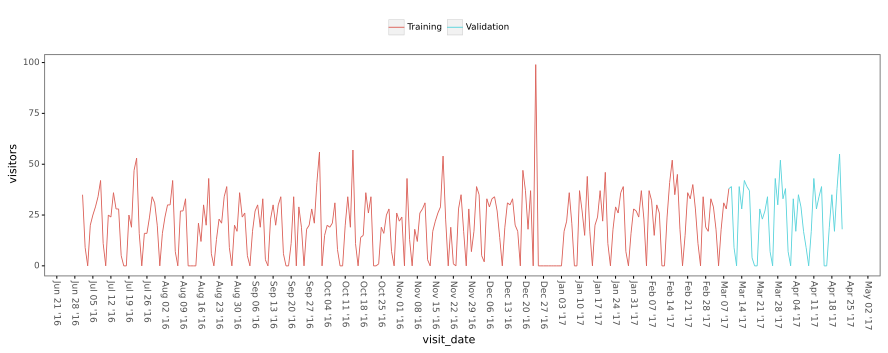

<ggplot: (8736334467910)>

In [25]:
plot_single_timeseries(vs.visits)

In [36]:
base_kernel = GPy.kern.RBF(input_dim=vs.trn.X.shape[1], variance=10.0, lengthscale=7.0)
periodic_kernel = GPy.kern.PeriodicMatern32(input_dim=1, variance=1., period=7.0)

kernel = base_kernel + periodic_kernel
#kernel = base_kernel

In [37]:
model = GPy.models.GPRegression(vs.trn.X, vs.trn.y, kernel)

In [38]:
# model.plot()

In [39]:
pred_dat = vs.predict_and_enframe(model)
pred_dat

,day,mean,var,sd,lower_bound,upper_bound,Prediction,day_of_week,day_of_month,holiday_flg,dataset,group
45161,182,36.207245,1.184520,1.088357,34.030532,38.383959,Prediction,0,1,0,Training,group
45162,183,17.443133,1.079836,1.039151,15.364830,19.521436,Prediction,1,2,0,Training,group
45163,184,3.203807,1.057624,1.028409,1.146990,5.260624,Prediction,2,3,0,Training,group
45164,185,19.614456,1.055801,1.027522,17.559412,21.669499,Prediction,3,4,0,Training,group
45165,186,22.660779,1.053877,1.026585,20.607608,24.713949,Prediction,4,5,0,Training,group
...,...,...,...,...,...,...,...,...,...,...,...,...
45452,473,24.162497,1.051797,1.025571,22.111354,26.213640,Prediction,4,18,0,Validation,group
45453,474,27.776156,1.058336,1.028755,25.718646,29.833665,Prediction,5,19,0,Validation,group
45454,475,29.348895,1.082271,1.040323,27.268250,31.429541,Prediction,6,20,0,Validation,group
45455,476,37.303896,1.083363,1.040847,35.222202,39.385590,Prediction,0,21,0,Validation,group


In [40]:
vs.predictors

['day_of_week', 'day_of_month', 'holiday_flg']

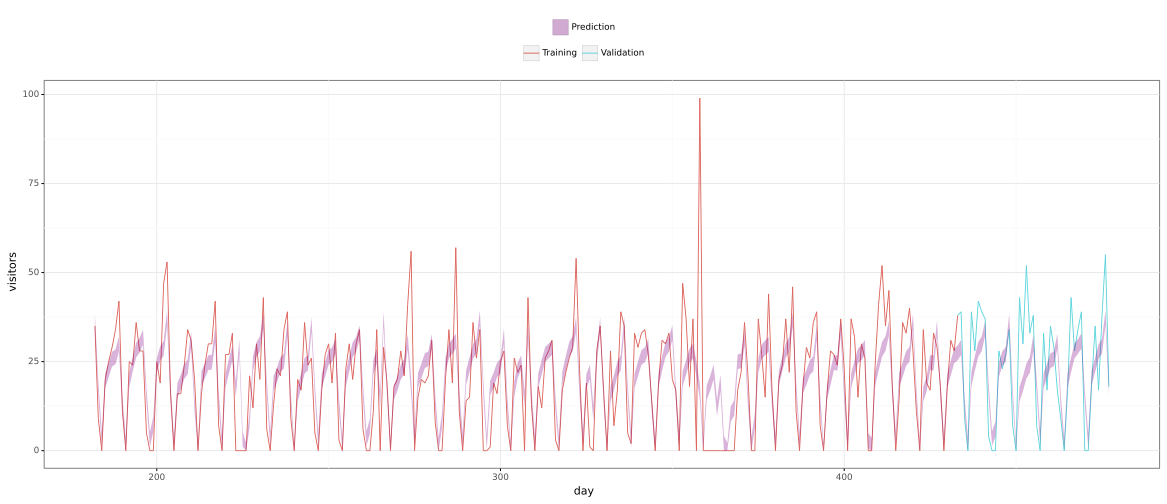

<ggplot: (8736311217532)>

In [41]:
(
    pn.ggplot() +
    pn.geom_line(data=vs.visits, mapping=pn.aes('day', 'visitors', color='dataset', group='group')) +
    pn.geom_ribbon(data=pred_dat, mapping=pn.aes(x='day', ymax='upper_bound', ymin='lower_bound', fill='Prediction'), 
                   alpha=0.3) +
    pn.scale_fill_manual(values = ["purple"]) +
    pn.theme_bw() +
    pn.theme(legend_title=pn.element_blank(),
             legend_position="top",
             figure_size=(20, 7)))